In [1]:
import argparse
import numpy as np
import pandas as pd
import pickle
import ast, os, sys
import neuroglancer
import matplotlib
import cv2
from skimage import img_as_ubyte
from matplotlib import pyplot as plt

In [2]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer
neuroglancer.set_server_bind_address(bind_port='33645')

Connecting dklab@192.168.1.12:3306


In [3]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/MD589'
contourpath = os.path.join(DIR, 'full_brain_volume_annotated.npy')
#contourpath = os.path.join('/home/eddyod/programming/pipeline_utility/neuroglancer', 'aligned_moving_instance.npy')
contour = np.load(contourpath)

In [ ]:
contour = img_as_ubyte(contour)

In [4]:
contour.dtype, contour.shape, np.median(contour), np.mean(contour), np.amax(contour)

(dtype('uint8'), (268, 3000, 5000), 0.0, 0.018506694527363185, 27)

In [ ]:
M = np.median(contour)
keep_mask = contour==M
vm = np.where(contour>M,0,1)
vm[keep_mask] = M
vm = vm.astype(np.uint8)
vm.dtype, vm.shape

In [5]:
vm = np.swapaxes(contour,0,2)
vm.shape, vm.dtype

((5000, 3000, 268), dtype('uint8'))

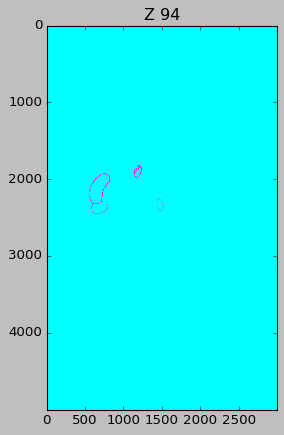

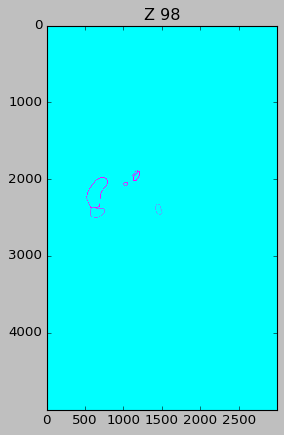

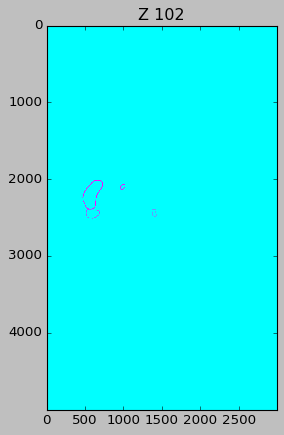

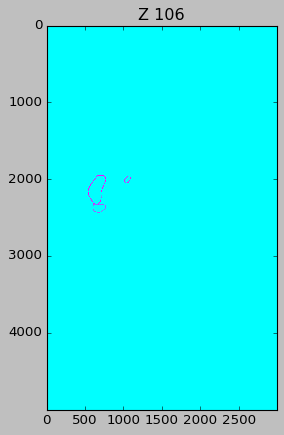

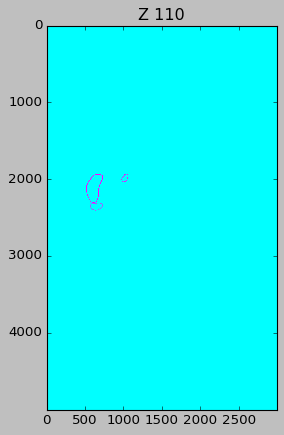

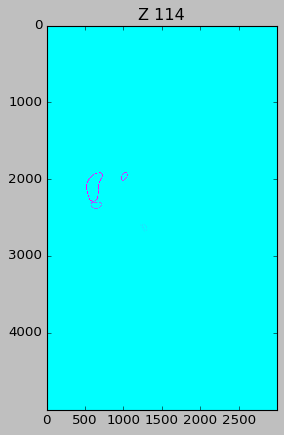

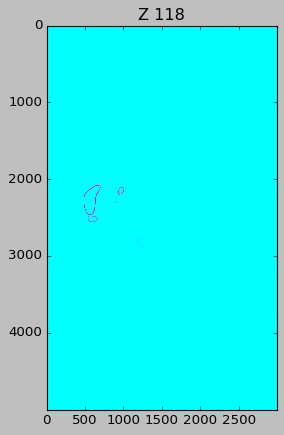

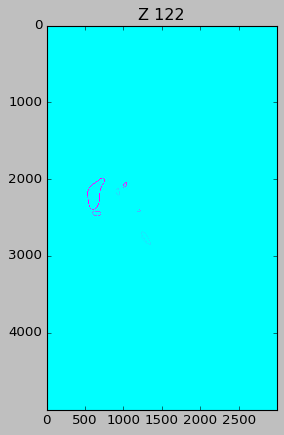

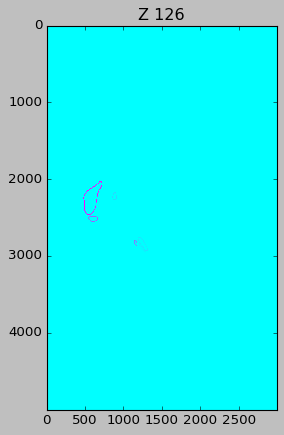

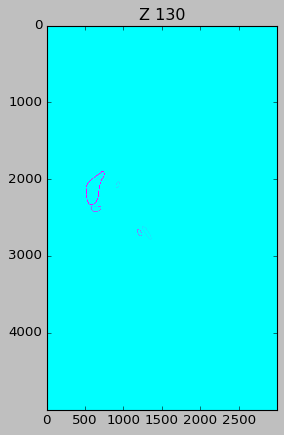

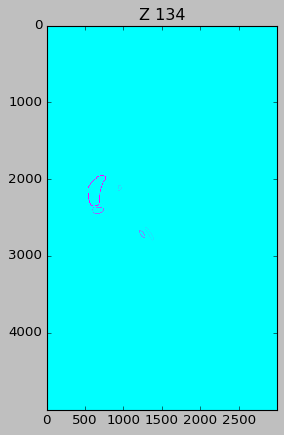

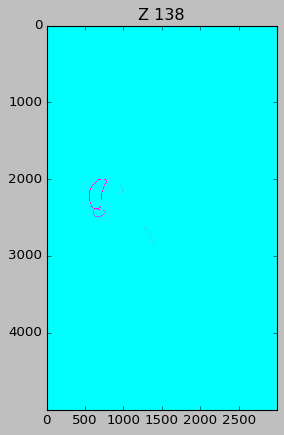

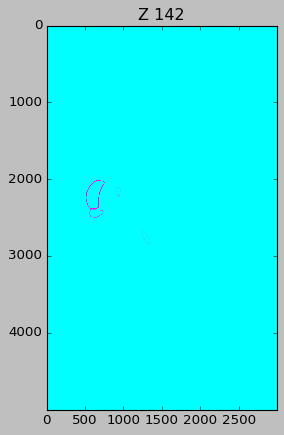

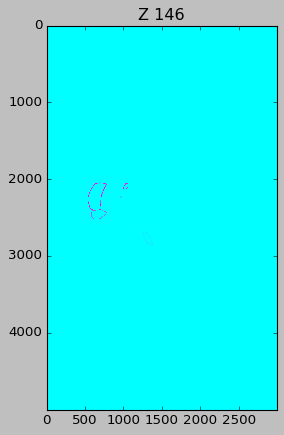

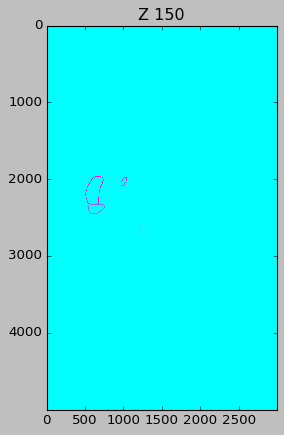

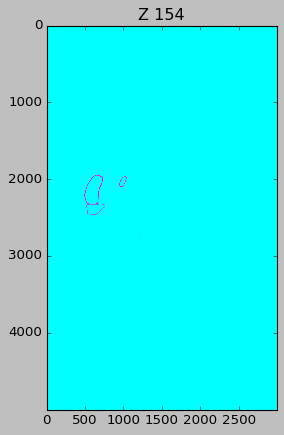

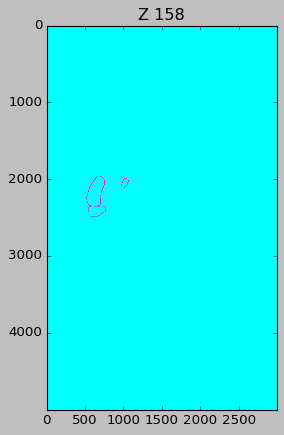

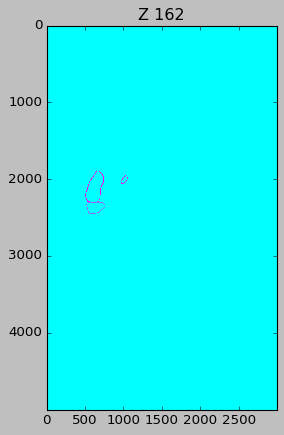

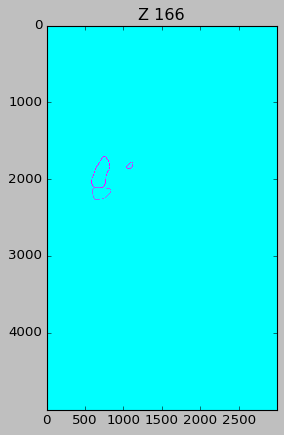

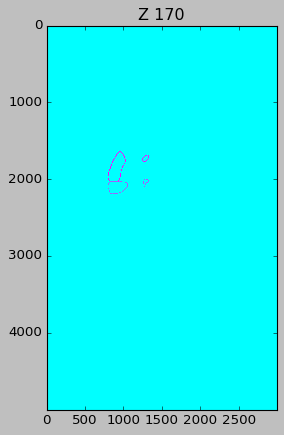

In [6]:
arr = vm
limit = 40
start = (arr.shape[2] // 2) - limit
end = start + limit * 2
#start = 209
#end = 220
nrows = end - start
ncols = 1
plt.style.use('classic')
for i in range(start, end, 4):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap="cool")
    plt.show()

In [ ]:
# Set ipython's max row display
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
csvfile = os.path.join(PATH, 'neuroglancer/contours','MD589_annotation_contours.csv')
df = pd.read_csv(csvfile)
structures_arr = df.name.unique()

In [ ]:
structures = structures_arr.tolist()
type(structures)

In [ ]:
df = MD589_annotations.groupby(['creator', 'name'])

In [ ]:
df.name.unique()

In [ ]:
df.loc[df['name'] == 'SNR'].groupby(['creator']).head()

In [ ]:
hand_annotations.head(4)

In [ ]:
animal = 'atlasV7'
target_structure = 'Tz'
str_contours_annotation, first_sec, last_sec = get_contours_from_annotations(animal, target_structure, hand_annotations, densify=0)

In [ ]:
first_sec, last_sec

In [7]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='nm',
    scales=[10, 10, 10])

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=vm,
            dimensions=neuroglancer.CoordinateSpace(
                names=['x', 'y', 'z'],
                units=['nm','nm','nm'],
                scales=[5, 5, 5]),
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = toNormalized(getDataValue());
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")
print(viewer)

http://127.0.0.1:33645/v/1471250f02f943b1c47b45f7e972bb987896f32e/


In [ ]:
csvfile = os.path.join(PATH, 'neuroglancer/contours', 'hand_annotations.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))
animal = 'MD589'
color_codes = {"3N": 3, "4N": 4, "5N": 5, "6N": 6, "Tz": 24, "VCA_L": 25, "VCA_R": 25, "SC":18, "IC":11}
viewer = neuroglancer.Viewer()
# Sets 'Image' layer to be MD585 prep2 images from S3
with viewer.txn() as s:
    s.layers[animal] = neuroglancer.ImageLayer(source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/'+animal+'_fullres')
    s.layout = 'xy' # '3d'/'4panel'/'xy'
print(viewer)

In [ ]:
neuroglancer.stop()

In [ ]:
structures = ['SC', 'IC']

for target_structure in structures:
    color = color_codes[target_structure]
    str_contours_annotation, first_sec, last_sec = get_contours_from_annotations(animal, target_structure, hand_annotations, densify=0)
    ng_structure_volume, xyz_offsets = add_structure_to_neuroglancer(viewer, str_contours_annotation, target_structure, animal, first_sec, last_sec, \
                                                        color_radius=2, xy_ng_resolution_um=5, threshold=1, color=color, \
                                                        solid_volume=False, no_offset_big_volume=True, save_results=False, \
                                                        return_with_offsets=True, add_to_ng=True, human_annotation=True )


In [ ]:
print(viewer)

In [ ]:
structures = ['3N', '4N', '5N', '6N', 'Tz']
for structure, volume, offset in zip(structures, structure_volumes,offsets):
    vm = np.swapaxes(volume,0,2)
    print(structure, vm.shape, offset)